In [2]:
import pandas as pd
import os
import re
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd

# Create initial datasets

### Setup input/output

In [3]:
# set working directory to project directory
#os.chdir('')

In [4]:
# set base directory
baseDIR = '../..'

# set input directory
inDIR = 'data/orig'

# set output directories
outDIR_clip = 'data/clip'
outDIR_vor = 'data/vor'
outDIR_vor_train = 'data/vor_train'
if not os.path.exists(os.path.join(baseDIR, outDIR_clip)):
    os.mkdir(os.path.join(baseDIR, outDIR_clip))
if not os.path.exists(os.path.join(baseDIR, outDIR_vor)):
    os.mkdir(os.path.join(baseDIR, outDIR_vor))
if not os.path.exists(os.path.join(baseDIR, outDIR_vor_train)):
    os.mkdir(os.path.join(baseDIR, outDIR_vor_train))
    
# set input file for biomass and associated data
inXLSX = 'PrairieDogPostPlagueBiomassProject_29April2025_spk.xlsx'

# set input file for coordinates used in spring 2023 sampling
inXLSX_coords = 'PDogBiomassCoordinatesChecklist_March2023.xlsx'

# set input file for 2021 'A' transects
pdog_a_trnx = 'A_transects_start-end_2021.shp'
# data originally in 'T:/3-GIS/ThunderBasin/Pdog_Vegetation/A_transects_start-end_2021.shp'

# set input file for 2021 'Roth' transects
pdog_roth_pts = 'finalbmz_2021.shp'
# data originally in 'T:/3-GIS/ThunderBasin/Bird_Habitats_Project/BMZ/finalbmz_2021.shp'

# set size of clipping quadrat for calculating biomass density
quad_size_m2 = 0.5

### Load data

In [5]:
# create an Excel file object for investigating contents
pdog_xlsx = pd.ExcelFile(os.path.join(baseDIR, inDIR, inXLSX))

coords_xlsx = pd.ExcelFile(os.path.join(baseDIR, inDIR, inXLSX_coords))

In [6]:
# display the sheet names in the .xlsx file
display(pdog_xlsx.sheet_names)

['CoordinateQAQC',
 'Soils_and_Env_Covariates',
 'MetaData',
 'Biomass',
 'PrairieDogBurrows',
 'ShrubMeasurements',
 'VOR',
 'SpeciesRichness']

In [7]:
# display the sheet names in the .xlsx file
display(coords_xlsx.sheet_names)

['Point checklist', 'summer 2022 clipping coord']

### Biomass clipping

In [8]:
# load necessary data
df_pdog_bm = pdog_xlsx.parse(sheet_name='Biomass', header=0)
df_pdog_sr = pdog_xlsx.parse(sheet_name='SpeciesRichness', header=0)
df_pdog_coords = pdog_xlsx.parse(sheet_name='MetaData', header=0)
#df_pdog_coords = pdog_xlsx.parse(sheet_name='CoordinateQAQC', header=0)
#df_pdog_coords_s23 = coords_xlsx.parse(sheet_name='Point checklist', header=0)

In [9]:
# rename point that is duplicated (see email from Katie)
#df_pdog_bm.loc[(df_pdog_bm['point'] == 'C4.5/C4_O') &
#                (df_pdog_bm['notes'].str.contains('duplicat')), 'point'] = 'C4_P/C4.8'

In [10]:
df_pdog_sr['point'][~df_pdog_sr['point'].isin(df_pdog_bm['point'].unique())].unique()

array([], dtype=object)

In [11]:
df_pdog_bm['point'][~df_pdog_bm['point'].isin(df_pdog_sr['point'].unique())].unique()

array(['Trashgrass'], dtype=object)

In [12]:
# rename points in clipping and cover datasets to match
df_pdog_sr.loc[df_pdog_sr['point'] == 'E51,3', 'point'] = 'E51.3'

In [13]:
# drop null dates
df_pdog_bm = df_pdog_bm[df_pdog_bm['date'] != 'na'].copy()

In [14]:
# fix data type for column 'SD total'
df_pdog_bm.loc[df_pdog_bm['SD total'].isin([-1, 'x']), 'SD total'] = np.nan
df_pdog_bm['SD total'] = df_pdog_bm['SD total'].astype(float)

In [15]:
# fix data type for column '% YUGL cover'
df_pdog_sr.loc[df_pdog_sr['% YUGL cover'].isin([-1, '2 plants?']), '% YUGL cover'] = np.nan
df_pdog_sr['% YUGL cover'] = df_pdog_sr['% YUGL cover'].astype(float)

In [16]:
# cover -1 to NAN for remaining columns
for c in df_pdog_sr.columns[df_pdog_sr.dtypes == float]:
    df_pdog_sr.loc[df_pdog_sr[c] == -1.0, c] = np.nan
for c in df_pdog_bm.columns[df_pdog_bm.dtypes == float]:
    df_pdog_bm.loc[df_pdog_bm[c] == -1.0, c] = np.nan

In [17]:
# drop any rows with missing biomass data
df_pdog_bm = df_pdog_bm[~df_pdog_bm['TotalCurrentYear'].isnull()].copy()

In [18]:
# calculate total biomass density in g/m^2 by summing SD and live and adjusting for quadrat size
df_pdog_bm['Total_Weight_(g/m^2)'] = df_pdog_bm[['TotalCurrentYear',
                                                 'SD total']].sum(axis=1) / quad_size_m2

In [19]:
# aggregate clipping data
df_pdog_bm_agg = df_pdog_bm.groupby(['date', 'point']).mean().reset_index()

# aggregate cover data
df_pdog_sr_agg = df_pdog_sr.groupby(['date', 'point']).mean().reset_index()

In [20]:
df_pdog_fnl = pd.merge_asof(df_pdog_bm_agg.sort_values('date'),
                         df_pdog_sr_agg.sort_values('date'),
                         on= 'date',
                         by=['point'],
                         direction= 'nearest',
                         tolerance= datetime.timedelta(days= 22),
                         suffixes=['_bm', '_sr'])

In [21]:
bad_plots = df_pdog_fnl.groupby('point').mean()[((df_pdog_fnl.groupby('point').mean()['%shrub Cover'] +
                                                  df_pdog_fnl.groupby('point').mean()['% YUGL cover']) >= 20)]

In [22]:
df_pdog_fnl['cacti_cladodes'] = df_pdog_fnl['cacti_cladodes'].transform(lambda x: 0.0 if np.isnan(x) else x)
df_pdog_fnl['%shrub Cover'] = df_pdog_fnl['%shrub Cover'].transform(lambda x: 0.0 if np.isnan(x) else x)
df_pdog_fnl['% YUGL cover'] = df_pdog_fnl['% YUGL cover'].transform(lambda x: 0.0 if np.isnan(x) else x)

In [23]:
df_pdog_fnl = df_pdog_fnl[(df_pdog_fnl['cacti_cladodes'] < 50) &
                          ((df_pdog_fnl['%shrub Cover'] +
                            df_pdog_fnl['% YUGL cover']) < 20) &
                          (~df_pdog_fnl['point'].isin(bad_plots.index))].copy()

<AxesSubplot:xlabel='year', ylabel='Total_Weight_(g/m^2)'>

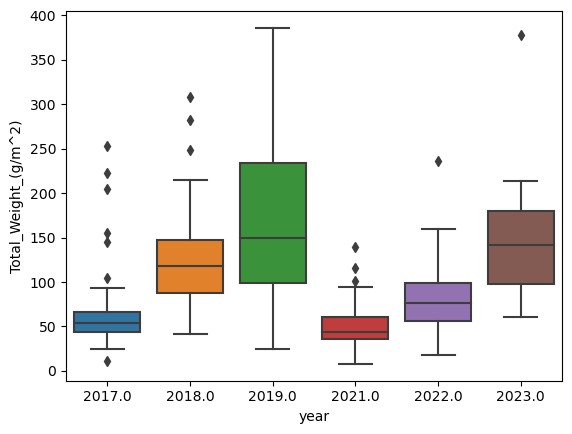

In [24]:
sns.boxplot(x='year', y='Total_Weight_(g/m^2)', data=df_pdog_fnl)

In [25]:
df_pdog_fnl['point'][~df_pdog_fnl['point'].isin(df_pdog_coords['point'].unique())].unique()

array([], dtype=object)

In [26]:
df_pdog_coords['point'][~df_pdog_coords['point'].isin(df_pdog_fnl['point'].unique())].unique()

array(['C4.8', 'C4.5/C4_O', 'PVSage Clayey', 'PVSage Loamy', 'GMDR B1',
       'GMDR B2', 'GMDR B3', 'NEX lakecreek-control',
       'NEX lakecreek-fire', 'NEX lakecreek-prairiedog',
       'NEX steckley-control', 'NEX steckley-prairiedog',
       'NEX wildcat-control', 'NEX wildcat-fire',
       'NEX wildcat-prairiedog', 'NEX westfork-control',
       'NEX westfork-fire', 'NEX westfork-prairiedog', 'E30_P/E30.3'],
      dtype=object)

In [27]:
# rename points with multiple names to be the name that matches in gdf_roth_pts
#pt_rename_list = ['C4_P/C4.8', 'C2_P/C2.7', 'E30_O/E30.6', 
#                  'C2_C/C2.1', 'C4_C/E36.3', 'C4_O/C4.5', 'C2_O/E37.2']
#df_pdog_fnl['point'] = df_pdog_fnl['point'].apply(lambda x: '/'.join([x.split('/')[1], x.split('/')[0]]) if x in pt_rename_list else x)

In [28]:
#df_pdog_fnl['point'][~df_pdog_fnl['point'].isin(df_pdog_coords['point'].unique())].unique()

In [29]:
df_pdog_coords = df_pdog_coords.rename(columns={'GPS_N': 'Mean.GPS_N.Biomass',
                                        'GPS_E': 'Mean.GPS_E.Biomass'})

In [30]:
# combine biomass and environmental datasets
df_pdog_fnl = pd.merge_asof(df_pdog_fnl.sort_values('date'),
                            df_pdog_coords[['point', 'date', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']].sort_values('date'),
                            on='date',
                            by='point',
                            tolerance=datetime.timedelta(days=7),
                            direction='nearest')

In [31]:
df_pdog_fnl[['Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']].isnull().any()

Mean.GPS_E.Biomass    False
Mean.GPS_N.Biomass    False
dtype: bool

In [32]:
#df_pdog_fnl[df_pdog_fnl[['Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']].isnull().any(axis=1)].sort_values('point')

In [33]:
df_pdog_fnl['Total_Weight_(g/m^2)'].isnull().any()

False

In [34]:
df_pdog_fnl.to_csv(os.path.join(baseDIR, outDIR_clip, 'TB_pdog_clip.csv'), index=False)

### VOR

In [35]:
df_pdog_vor = pdog_xlsx.parse(sheet_name='VOR', header=0)

In [36]:
# rename coords columns to match
#df_pdog_coords_s23 = df_pdog_coords_s23.rename(columns={'Transect.point': 'point',
#                                   'UTM_13N_X': 'Mean.GPS_E.Biomass',
#                                   'UTM_13N_Y': 'Mean.GPS_N.Biomass'})
#s23_point_rename = {
#    'NEX_LC_PD': 'NEX lakecreek-prairiedog', 
#    'NEX_LC_Fire': 'NEX lakecreek-fire', 
#    'NEX_LC_Control': 'NEX lakecreek-control', 
#    'GMDR_B1': 'GMDR B1', 
#    'GMDR_B2': 'GMDR B2',
#    'GMDR_B3': 'GMDR B3', 
#    'NEX_Steckley_PD/E57.1': 'NEX steckley-prairiedog', 
#    'NEX_Steckley_Control': 'NEX steckley-control',
#    'PVSage_Loamy': 'PVSage Loamy', 
#    'PVSage_Clayey': 'PVSage Clayey', 
#    'NEX_WF_PD': 'NEX westfork-prairiedog', 
#    'NEX_WF_Fire': 'NEX westfork-fire',
#    'NEX_WF_Control': 'NEX westfork-control', 
#    'NEX_WC_PD': 'NEX wildcat-prairiedog',
#    'NEX_WC_Fire': 'NEX wildcat-fire',
#    'NEX_WC_Control': 'NEX wildcat-control'
#}

# rename coords points to match
#df_pdog_coords_s23['point'] = df_pdog_coords_s23['point'].apply(lambda x: s23_point_rename[x] if x in s23_point_rename.keys() else x)


In [37]:
# drop point that is duplicated (see email from Katie)
#df_pdog_vor = df_pdog_vor[~((df_pdog_vor['point'] == 'C4.5/C4_O') &
#             (df_pdog_vor['notes'].str.contains('duplicate')))]

In [38]:
# define non-veg species
non_veg_spp = ['ANT MOUND', 'BARE', 'DUNG', 'LICHEN', 'PRAIRIE DOG MOUND', 'LITTER', 'LITT']

# create list of species to drop from VOR data
vor_spp_drop_list = ['ARFI', 'ARTR', 'ARCA', 'ATCA', 'ATGA', 'CHVI', 'ERNA', 'EREF', 'KRLA', 'RHTR', 'SAVE',
                     'arfi', 'artr', 'arca', 'atca', 'atga', 'chvi', 'erna', 'eref', 'krla', 'rhtr', 'save',
                     'OPPO', 'oppo',
                     'SD ARTR', 'SD ATCA', 'PASM/SD ARTR', 'AGCR/ARTR', 'OPPO/PASM']

In [39]:
# drop VOR readings in species list
df_pdog_vor = df_pdog_vor[~df_pdog_vor['species'].isin(vor_spp_drop_list)].copy()
# convert missing and 90+ readings to NaN
df_pdog_vor.loc[df_pdog_vor['VOR'].isin([-1, '90+']), 'VOR'] = np.nan
# drop any readings of non-veg species that are > 0
df_pdog_vor = df_pdog_vor[~(df_pdog_vor['species'].isin(non_veg_spp) & (df_pdog_vor['VOR'] > 0))]

In [40]:
#df_pdog_vor[df_pdog_vor['species'].isin(non_veg_spp)]

In [41]:
# convert to float
df_pdog_vor['VOR'] = df_pdog_vor['VOR'].astype(float)

In [42]:
# reset the index
df_pdog_vor = df_pdog_vor.reset_index(drop=True)

In [43]:
# separate low and high VOR readings to separate columns
df_pdog_vor = df_pdog_vor.pivot(index=['year', 'date', 'point', 'distance (m)', 'VOR position'], 
                  columns=['reading'], values='VOR').reset_index()
# rename VOR columns to match other datasets
df_pdog_vor = df_pdog_vor.rename(columns={'low': 'Low_cm',
                                          'high': 'High_cm'})
# drop name associated with columns
df_pdog_vor.columns.name = None

# drop VOR where low > high as suspected data entry errors
df_pdog_vor = df_pdog_vor[df_pdog_vor['Low_cm'] <= df_pdog_vor['High_cm']]

In [44]:
#s23_mask = (df_pdog_vor['date'] > datetime.datetime(2023,1,1)) & \
#            (df_pdog_vor['date'] < datetime.datetime(2023,5,1))

In [45]:
#df_pdog_vor['point'][~df_pdog_vor['point'].isin(df_pdog_coords['point'].unique()) & 
#                     ~s23_mask].unique()

In [46]:
df_pdog_vor['point'][~df_pdog_vor['point'].isin(df_pdog_coords['point'].unique())].unique()

array([], dtype=object)

In [47]:
#pt_rename_list_vor = ['C2_C/C2.1', 'C2_O/E37.2', 'C2_P/C2.7', 'C4_C/E36.3',
#                      'C4_O/C4.5', 'C4_P/C4.8', 'E30_O/E30.6', 'E30_P/E30.3']

In [48]:
#df_pdog_vor.loc[~s23_mask, 'point'] = df_pdog_vor['point'].apply(lambda x: '/'.join([x.split('/')[1], x.split('/')[0]]) if x in pt_rename_list_vor else x)[~s23_mask]

In [49]:
#df_pdog_vor['point'][~df_pdog_vor['point'].isin(df_pdog_coords['point'].unique()) & 
#                     ~s23_mask].unique()

In [50]:
#df_pdog_vor.loc[(df_pdog_vor['point'] == 'E30.3/E30_P') & ~s23_mask, 'point'] = 'E30_P'

In [51]:
#df_pdog_vor['point'][~df_pdog_vor['point'].isin(df_pdog_coords['point'].unique()) & 
#                     ~s23_mask].unique()

In [52]:
#df_pdog_vor['point'][~df_pdog_vor['point'].isin(df_pdog_coords_s23['point'].unique()) & 
#                     s23_mask].unique()

In [53]:
#df_pdog_vor.loc[(df_pdog_vor['point'] == 'E30_P') & s23_mask, 'point'] = 'E30_P/E30.3'

In [54]:
#df_pdog_vor['point'][~df_pdog_vor['point'].isin(df_pdog_coords_s23['point'].unique()) & 
#                     s23_mask].unique()

In [55]:
# manually change point name to match coordinates in Metadata sheet
df_pdog_vor.loc[(df_pdog_vor['point'] == 'E30_P/E30.3') & (df_pdog_vor['date'] == pd.to_datetime('2023-7-27')), 'point'] = 'E30_P'

In [56]:
df_pdog_vor_agg = df_pdog_vor.drop(columns=['distance (m)', 'VOR position']).groupby(['year', 'date', 'point']).mean().reset_index()

In [57]:
#s23_mask_agg = (df_pdog_vor_agg['date'] > datetime.datetime(2023,1,1)) & \
#(df_pdog_vor_agg['date'] < datetime.datetime(2023,5,1))

In [58]:
#df_pdog_vor['point'][~df_pdog_vor['point'].isin(df_pdog_coords['point'].unique()) & 
#                     ~s23_mask].unique()

In [59]:
#df_pdog_vor_agg['point'][~df_pdog_vor_agg['point'].isin(df_pdog_coords['point'].unique()) & 
#                     ~s23_mask_agg].unique()

In [60]:
#df_pdog_vor_out = pd.concat(
#    [pd.merge(df_pdog_vor_agg[~s23_mask_agg],
#              df_pdog_coords[['point', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']],
#              how='left',
#              on=['point']),
#     pd.merge(df_pdog_vor_agg[s23_mask_agg],
#              df_pdog_coords_s23[['point', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']],
#              how='left',
#              on=['point'])
#    ])
     

In [61]:
# combine biomass and environmental datasets
df_pdog_vor_out = pd.merge_asof(df_pdog_vor_agg.sort_values('date'),
                                df_pdog_coords[['point', 'date', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']].sort_values('date'),
                                on='date',
                                by='point',
                                tolerance=datetime.timedelta(days=7),
                                direction='nearest')

In [62]:
df_pdog_vor_out[['Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']].isnull().any()

Mean.GPS_E.Biomass    True
Mean.GPS_N.Biomass    True
dtype: bool

In [63]:
df_pdog_vor_out[df_pdog_vor_out[['Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']].isnull().any(axis=1)].sort_values('point')

,year,date,point,High_cm,Low_cm,Mean.GPS_E.Biomass,Mean.GPS_N.Biomass
219,2024,2024-07-16,E8.2,22.421053,5.631579,NaN,NaN
205,2024,2024-07-16,ROTH143_C,6.529412,1.058824,NaN,NaN


In [64]:
# manually checked the above entries in Metadata sheet and either coords are missing or entry is missing altogether
df_pdog_vor_out = df_pdog_vor_out.dropna(subset=['Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass'], how='any')

In [65]:
df_pdog_vor_out.to_csv(os.path.join(baseDIR, outDIR_vor, 'TB_pdog_vor.csv'), index=False)

In [66]:
df_pdog_vor_bm_out = pd.merge_asof(df_pdog_vor_agg.sort_values('date'),
                                   df_pdog_fnl.sort_values('date'), 
                                   on='date',
                                   by=['point'],
                                   direction= 'nearest',
                                   tolerance= datetime.timedelta(days= 22),
                                   suffixes=['_vor', '_bm'])

In [67]:
df_pdog_vor_bm_out = df_pdog_vor_bm_out[~df_pdog_vor_bm_out['Total_Weight_(g/m^2)'].isnull()]

In [68]:
# rename columns to match other VOR training data
df_pdog_vor_bm_out = df_pdog_vor_bm_out.rename(columns={'date': 'Date',
                                                        'Total_Weight_(g/m^2)': 'Total Weight (g/m^2)',
                                                        'year_vor': 'Year'})
# keep only necessary columns
df_pdog_vor_bm_out = df_pdog_vor_bm_out[['Date', 'point', 'High_cm', 'Low_cm', 'Total Weight (g/m^2)', 'Year',
                                         '%shrub Cover', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass']]

In [69]:
df_pdog_vor_bm_out.columns

Index(['Date', 'point', 'High_cm', 'Low_cm', 'Total Weight (g/m^2)', 'Year',
       '%shrub Cover', 'Mean.GPS_E.Biomass', 'Mean.GPS_N.Biomass'],
      dtype='object')

In [70]:
df_pdog_vor_bm_out

,Date,point,High_cm,Low_cm,Total Weight (g/m^2),Year,%shrub Cover,Mean.GPS_E.Biomass,Mean.GPS_N.Biomass
123,2023-07-19,ROTH143_P,13.600000,2.250000,142.821,2023,0.000,499624.92,4804572.27
124,2023-07-19,ROTH143_O,15.400000,2.850000,89.711,2023,0.000,499136.03,4804821.94
125,2023-07-19,ROTH114_P,21.300000,5.350000,139.593,2023,0.000,499584.69,4804314.13
126,2023-07-19,ROTH114_O,46.850000,10.200000,191.812,2023,0.000,499848.90,4805724.26
127,2023-07-19,ROTH101_P,16.950000,5.350000,170.618,2023,0.000,498246.37,4806479.29
128,2023-07-19,ROTH101_C,32.200000,14.900000,214.077,2023,0.000,499991.45,4807392.04
138,2023-07-20,ROTH114_C,15.100000,4.700000,143.484,2023,0.000,498712.10,4803991.65
155,2023-07-26,C2_O/E37.2,15.000000,2.450000,84.727,2023,0.500,489526.09,4813611.51
156,2023-07-26,C2_P/C2.7,20.400000,6.100000,129.780,2023,0.000,490408.37,4812385.16
159,2023-07-26,C4_O/C4.5,38.789474,11.894737,378.490,2023,0.000,494369.99,4811539.46


In [71]:
df_pdog_vor_bm_out.to_csv(os.path.join(baseDIR, outDIR_vor_train, 'TB_pdog_vor_train.csv'), index=False)

# Questions
* ID's missing from GPS (see above) - can get A. and Roth from shapefile(s) on T:
    * (A are in ThunderBasin/PdogVegetation; Roth are in BMZ file in ThunderBasin/BirdHabitatsProject/BMZ)